In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("ds701-fa24-midterm.ipynb")

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# NBA Shot Data Midterm Challenge

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

if not os.path.exists("./datasets"):
    os.makedirs("./datasets")
    os.system("unzip ./archive.zip -d ./datasets")

datasets = sorted(os.listdir("./datasets"))
print(datasets)

['test.csv', 'test.csv:Zone.Identifier', 'train.csv', 'train.csv:Zone.Identifier']


You have the following datasets in the ./datasets directory:

* train.csv
* test.csv

For questions 1, 2, and 4, work with the `train.csv` file. Use both `train.csv` and `test.csv` for question 3 (the prediction task).

## Part 1: Exploratory analysis, visualization and outlier detection.


Please answer the following seven questions.

In [5]:
df = pd.read_csv("./datasets/train.csv")

In [6]:
max(df["QUARTER"].unique())

np.float64(8.011395288387607)

<!-- BEGIN QUESTION -->

### Question 1-1: Unique Players

How many unique players are there? Return this value as an integer.

In [7]:
def find_n_unique_players(df):
    """
    Find and return the number of unique players as an integer.
    """
    # player id has some problems, same name multiple player id, so I use play name to calculate
    return len(df['PLAYER_NAME'].unique())

n_unique_players = find_n_unique_players(df)
print("Number of unique players", n_unique_players)

Number of unique players 2156


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-2: Played most games

Which player has played in the most games normalized by number of games per season (82) played in the dataset? 

Return a Pandas Series with an index of ['PLAYER_NAME', 'GAME_COUNT', 'GAMES_PER_SEASON'].

In [8]:
def find_top_player_most_games(df):
    """
    Find and return the player with the most games normalized by number of games per season (82) played in the dataset.
    """

    # groupby game date to calculate the number of games they played, game id has the same issue as player id
    game_played_singleGames = df.groupby(["PLAYER_NAME","GAME_DATE"]).size().reset_index()
    game_played_singleGames = game_played_singleGames.groupby(["PLAYER_NAME"]).size().reset_index()
    game_played_singleGames = pd.DataFrame(game_played_singleGames)
    game_played_singleGames = game_played_singleGames.rename(columns={0:"single_games_count"})
    game_played_singleGames = game_played_singleGames.sort_values(by = "single_games_count", ascending=False)
    game_played_singleGames['GAMES_PER_SEASON'] = game_played_singleGames["single_games_count"] / 82.0
    game_played_singleGames = game_played_singleGames.sort_values(by = 'GAMES_PER_SEASON', ascending=False)
    ans = game_played_singleGames[['PLAYER_NAME','GAMES_PER_SEASON']]
    ans = ans.iloc[0]
    return ans

top_player = find_top_player_most_games(df)
print(f"Player with the most games normalized by seasons: {top_player['PLAYER_NAME']} with {top_player['GAMES_PER_SEASON']} games per season")


Player with the most games normalized by seasons: LeBron James with 18.195121951219512 games per season


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-3: Highest Shot Players

Find the 10 players with the highest shot success rate in the 4th quarter that have taken at least 2000 shots in the 4th quarter. 

Return a Pandas dataframe of length 10 with the following columns 

- 'PLAYER_NAME' 
- 'SHOT_COUNT'  
- 'SHOTS_MADE' 
- 'SHOT_SUCCESS_RATE'

In [9]:
def find_top_10_players_q4(df):
    """
    Find and return the 10 players with the highest shot success rate in the 4th quarter that have taken at least 2000 shots in the 4th quarter.
    """
    # quarter is a float number
    df["QUARTER_categorized"] = df["QUARTER"].apply(lambda x:int(x))
    df = df[df["QUARTER_categorized"] == 4]
    shot_made = df.groupby(["PLAYER_NAME"]).size().reset_index()
    shot_made = shot_made[shot_made[0]>=2000]
    shot_made = shot_made.rename(columns = {0:"SHOT_COUNT"})
    # select the ones that should be considered
    listOfCandidates = shot_made["PLAYER_NAME"]
    df = df[df["PLAYER_NAME"].isin(listOfCandidates)]
    shot_success = df[df["SHOT_MADE"] == True]
    shot_success = shot_success.groupby(["PLAYER_NAME"]).size().reset_index()
    shot_success = pd.DataFrame(shot_success)
    shot_success = shot_success.rename(columns = {0:"SHOTS_MADE"})
    ans = shot_success.merge(shot_made, on = ["PLAYER_NAME"])
    ans["SHOT_SUCCESS_RATE"] = ans["SHOTS_MADE"] / ans["SHOT_COUNT"]
    ans = ans.sort_values(by = 'SHOT_SUCCESS_RATE',ascending=False)
    ans = ans[["PLAYER_NAME","SHOT_COUNT","SHOTS_MADE","SHOT_SUCCESS_RATE"]].reset_index(drop = True)
    ans = ans.iloc[0:10]
    return ans


top_players_q4 = find_top_10_players_q4(df)
print(top_players_q4)


             PLAYER_NAME  SHOT_COUNT  SHOTS_MADE  SHOT_SUCCESS_RATE
0  Giannis Antetokounmpo        2230        1227           0.550224
1         Thaddeus Young        2026        1016           0.501481
2      LaMarcus Aldridge        2467        1203           0.487637
3             Chris Bosh        2043         996           0.487518
4            Tony Parker        2092        1019           0.487094
5           Al Jefferson        2111        1027           0.486499
6           LeBron James        5467        2632           0.481434
7          Stephen Curry        2657        1264           0.475725
8             Chris Paul        3092        1463           0.473157
9          Zach Randolph        2280        1078           0.472807


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-4: Most shots made

Find the 10 players with the most SHOT_MADE beyond 23 feet of the basket who played in more than 500 games.

Return a Pandas dataframe of length 10 with the following columns 

- 'PLAYER_NAME' 
- 'GAME_COUNT'  
- 'SHOTS_MADE_BEYOND_23'

In [10]:
def find_top_players_beyond_23_feet(df):
    """
    Find and return the 10 players with the most SHOT_MADE beyond 23 feet of the basket who played in more than 500 games.
    """
    game_played_singleGames = df.groupby(["PLAYER_NAME","GAME_DATE"]).size().reset_index()
    game_played_singleGames = game_played_singleGames.groupby(["PLAYER_NAME"]).size().reset_index()
    game_played_singleGames = pd.DataFrame(game_played_singleGames)
    game_played_singleGames = game_played_singleGames.rename(columns={0:"GAME_COUNT"})
    game_played_singleGames = game_played_singleGames[game_played_singleGames["GAME_COUNT"] > 500]
    listOfCandidates = game_played_singleGames["PLAYER_NAME"]
    df = df[df["PLAYER_NAME"].isin(listOfCandidates)]
    df = df[df["SHOT_DISTANCE"] > 23]
    df = df[df["SHOT_MADE"] == True]
    shot_person = df.groupby(["PLAYER_NAME"]).size().reset_index()
    shot_person = pd.DataFrame(shot_person)
    shot_person = shot_person.rename(columns = {0:"SHOTS_MADE_BEYOND_23"})
    shot_person = shot_person.sort_values(by = "SHOTS_MADE_BEYOND_23", ascending=False)
    shot_person = shot_person.merge(game_played_singleGames, on = ["PLAYER_NAME"],how = 'left')
    shot_person = shot_person.iloc[0:10].reset_index(drop=True)
    shot_person = shot_person[["PLAYER_NAME","GAME_COUNT","SHOTS_MADE_BEYOND_23"]]
    return shot_person
    

top_players_beyond_23 = find_top_players_beyond_23_feet(df)
print(top_players_beyond_23)

      PLAYER_NAME  GAME_COUNT  SHOTS_MADE_BEYOND_23
0   Stephen Curry         954                  2643
1    James Harden        1072                  2193
2  Damian Lillard         842                  1993
3    LeBron James        1492                  1754
4   Klay Thompson         792                  1590
5    Kevin Durant        1061                  1543
6      Kyle Lowry        1131                  1516
7     Paul George         865                  1471
8     Eric Gordon         885                  1458
9     Kyle Korver        1206                  1455


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-5: Close shots made

Find the 10 players with the most SHOT_MADE within 10 feet of the basket who played in more than 500 games.

Return a Pandas dataframe of length 10 with the following columns 

- 'PLAYER_NAME' 
- 'GAME_COUNT'  
- 'SHOTS_MADE_INSIDE_10'


In [11]:
def find_top_players_within_10_feet(df):
    """
    Find and return the 10 players with the most SHOT_MADE within 10 feet of the basket who played in more than 500 games.
    """
    game_played_singleGames = df.groupby(["PLAYER_NAME","GAME_DATE"]).size().reset_index()
    game_played_singleGames = game_played_singleGames.groupby(["PLAYER_NAME"]).size().reset_index()
    game_played_singleGames = pd.DataFrame(game_played_singleGames)
    game_played_singleGames = game_played_singleGames.rename(columns={0:"GAME_COUNT"})
    game_played_singleGames = game_played_singleGames[game_played_singleGames["GAME_COUNT"] > 500]
    listOfCandidates = game_played_singleGames["PLAYER_NAME"]
    df = df[df["PLAYER_NAME"].isin(listOfCandidates)]
    df = df[df["SHOT_DISTANCE"] <10]
    df = df[df["SHOT_MADE"] == True]
    shot_person = df.groupby(["PLAYER_NAME"]).size().reset_index()
    shot_person = pd.DataFrame(shot_person)
    shot_person = shot_person.rename(columns = {0:"SHOTS_MADE_INSIDE_10"})
    shot_person = shot_person.sort_values(by = "SHOTS_MADE_INSIDE_10", ascending=False)
    shot_person = shot_person.merge(game_played_singleGames, on = ["PLAYER_NAME"],how = 'left')
    shot_person = shot_person.iloc[0:11].reset_index(drop=True)
    shot_person = shot_person[["PLAYER_NAME","GAME_COUNT","SHOTS_MADE_INSIDE_10"]]
    return shot_person
    

top_players_below_10 = find_top_players_within_10_feet(df)
print(top_players_below_10)

              PLAYER_NAME  GAME_COUNT  SHOTS_MADE_INSIDE_10
0            LeBron James        1492                  7370
1           Dwight Howard        1225                  5373
2   Giannis Antetokounmpo         790                  4255
3       Russell Westbrook        1162                  4169
4             Dwyane Wade        1053                  4160
5           Zach Randolph         997                  3948
6          Thaddeus Young        1151                  3809
7               Pau Gasol        1058                  3735
8           Anthony Davis         735                  3592
9         Carmelo Anthony        1259                  3571
10             Tim Duncan         941                  3568


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-6: Shot Types

For each position, find the 2 most successful types of action taken during a shot (ACTION_TYPE). 

Return a dataframe with the columns:

- 'POSITION'                 
- 'ACTION_TYPE'  
- 'SUCCESSFUL_SHOTS'

In [12]:
def find_top_actions_by_position(df):
    """
    Find and return the 2 most successful types of action taken during a shot for each position.
    """
    df = df[df["SHOT_MADE"] == True]
    position_act = df.groupby(['POSITION','ACTION_TYPE']).size().reset_index()
    position_act = position_act.rename(columns = {0:"SUCCESSFUL_SHOTS"})
    position_act = position_act.sort_values(by = "SUCCESSFUL_SHOTS", ascending = False).reset_index(drop = True)
    selected = {}
    top2_success = pd.DataFrame({"POSITION":[position_act["POSITION"][0]], "ACTION_TYPE":[position_act["ACTION_TYPE"][0]], "SUCCESSFUL_SHOTS":[position_act["SUCCESSFUL_SHOTS"][0]]})
    selected[position_act["POSITION"][0]] = 1
    # if there is less than two answers, save the answer
    for i in range(1,len(position_act)):
        if position_act["POSITION"][i] in selected:
            if selected[position_act["POSITION"][i]] == 2:
                continue
            else:
                selected[position_act["POSITION"][i]] += 1
                new_append = pd.DataFrame({"POSITION":[position_act["POSITION"][i]], "ACTION_TYPE":[position_act["ACTION_TYPE"][i]], "SUCCESSFUL_SHOTS":[position_act["SUCCESSFUL_SHOTS"][i]]})
                top2_success = pd.concat([top2_success,new_append], ignore_index=True)
        else:
            selected[position_act["POSITION"][i]] = 1
            new_append = pd.DataFrame({"POSITION":[position_act["POSITION"][i]], "ACTION_TYPE":[position_act["ACTION_TYPE"][i]], "SUCCESSFUL_SHOTS":[position_act["SUCCESSFUL_SHOTS"][i]]})
            top2_success = pd.concat([top2_success,new_append], ignore_index=True)
    top2_success = top2_success.sort_values(by= 'POSITION', ascending=True).reset_index(drop = True)
    return top2_success
    
    
top_actions_by_position = find_top_actions_by_position(df)
print(top_actions_by_position)

    POSITION                 ACTION_TYPE  SUCCESSFUL_SHOTS
0          C                   Jump Shot             59814
1          C                  Layup Shot             45622
2       C-PF                   Jump Shot               699
3       C-PF                  Layup Shot               438
4         PF                   Jump Shot            106647
5         PF                  Layup Shot             42812
6       PF-C                  Layup Shot               406
7       PF-C                   Jump Shot               841
8      PF-SF                  Layup Shot               333
9      PF-SF                   Jump Shot              1312
10        PG                   Jump Shot            114409
11        PG          Driving Layup Shot             47075
12     PG-SF                   Jump Shot               183
13     PG-SF          Driving Layup Shot                27
14     PG-SG          Driving Layup Shot               647
15     PG-SG                   Jump Shot              18

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-7: Additional Insight

One more insight of your choice. You can, for example, create a statistic that represents how **clutch** a player is. For example, how many shots they make in the last 4 minutes of the 4th quarter. You can of course choose something different, and this does not have to be at the player level - could be team-level instead. 

In [18]:
# I want to see how boston Team ranked among all these teams in 2023-2024 year
def team_shot(team_name):
    team_performance = df[df["SEASON_2"] == '2023-24'].copy()
    # count score of each team, then rank them
    team_performance["score"] = 0
    team_performance.loc[team_performance["SHOT_TYPE"] == "2PT Field Goal", "score"] = 2 * team_performance["SHOT_MADE"]
    team_performance.loc[team_performance["SHOT_TYPE"] == "3PT Field Goal", "score"] = 3 * team_performance["SHOT_MADE"]
    team_performance = team_performance.groupby("TEAM_NAME").agg(Shots_made=("SHOT_MADE", "sum"), Shots_count=("SHOT_MADE", "size"), shot_scores = ("score", "sum"))
    team_performance["SHOT_SUCCESS_RATE"] = team_performance["Shots_made"] / team_performance["Shots_count"]
    team_performance = team_performance.sort_values(by = "shot_scores", ascending= False).reset_index()
    team_num = len(team_performance)
    rank = team_performance[team_performance["TEAM_NAME"] == team_name].index[0] + 1
    team = team_performance[team_performance["TEAM_NAME"] == team_name]
    shotMade = team["Shots_made"].iloc[0]
    successRate = team["SHOT_SUCCESS_RATE"].iloc[0]
    score = team["shot_scores"].iloc[0]
    return rank, shotMade, successRate, team_num, score

rank, shotMade, successRate, team_num, score = team_shot("Boston Celtics")
print(f"Boston Celtics is ranked  {rank} out of {team_num} teams in the 2023-24 season, with the shot made of {shotMade} and success rate {successRate} and score {score}")

Boston Celtics is ranked  2 out of 30 teams in the 2023-24 season, with the shot made of 2887 and success rate 0.4887421703064161 and score 6845


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 2: Clustering for Player Profiles



Create player profiles based on attributes like (not limited to these):

- Shot types (SHOT_TYPE, ACTION_TYPE).
- Shot zones (BASIC_ZONE, ZONE_NAME).
- Shot success rate (SHOT_MADE).
- Shot distance (SHOT_DISTANCE).

Consider subsets of years to make the clustering faster:

- 2012-2016
- 2016-2020
- 2020-2024

Based on the metric results, pick a k-value and plot centroids over these three 4-year periods and analyze - how do the clusters change? 

Add some additional analysis based on the players included in the cluster. Does the cluster have a common trait or explanation? Can you explain outliers? Then, try to improve the silhouette score by experimenting with other features and/or dimensionality reduction techniques.

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

In [20]:
df.columns

Index(['SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID', 'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'GAME_ID', 'HOME_TEAM', 'AWAY_TEAM', 'SHOT_MADE', 'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'QUARTER_categorized'], dtype='object')

In [21]:
subset2012 = ["2012-13","2013-14","2014-15","2015-16"]
subset2016 = ["2016-17","2017-18","2018-19","2019-20"]
subset2020 = ["2020-21","2021-22","2022-23","2023-24"]
def player_subset(subset2012):
    df_2012 = df[df["SEASON_2"].isin(subset2012)]
    df_2012 = df_2012.groupby("PLAYER_NAME").agg(Shot_distance_mean = ("SHOT_DISTANCE","mean"), minleft_mean = ("MINS_LEFT","mean"), shot_made = ("SHOT_MADE","sum"), shot_count = ("SHOT_MADE","size"),
                                                action_type = ("ACTION_TYPE", lambda x: x.mode()[0]), shot_type = ("SHOT_TYPE", lambda x: x.mode()[0]),
                                                basic_zone = ("BASIC_ZONE", lambda x: x.mode()[0]), zone_name = ("ZONE_NAME", lambda x: x.mode()[0]))
    df_2012["shot_rate"] = df_2012["shot_made"] / df_2012["shot_count"]
    label_encoder = preprocessing.LabelEncoder()
    df_2012["action_type"] = label_encoder.fit_transform(df_2012["action_type"])
    df_2012["shot_type"] = label_encoder.fit_transform(df_2012["shot_type"])
    df_2012["basic_zone"] = label_encoder.fit_transform(df_2012["basic_zone"])
    df_2012["zone_name"] = label_encoder.fit_transform(df_2012["zone_name"])
    return df_2012
df_2012 = player_subset(subset2012)
df_2016 = player_subset(subset2016)
df_2020 = player_subset(subset2020)

In [22]:
print(df_2012[df_2012["Shot_distance_mean"] > 100])
# there is one person that only shot once at the distance that is out of 100, whtch is considered as an outliner
df_2012 = df_2012[df_2012["Shot_distance_mean"] < 100]

             Shot_distance_mean  minleft_mean  shot_made  shot_count  action_type  shot_type  basic_zone  zone_name  shot_rate
PLAYER_NAME                                                                                                                   
Melvin Ely           157.216935           3.0          1           1            9          0           4          0        1.0


In [23]:
print(df_2020[df_2020["Shot_distance_mean"] > 50])
# this is also considered as an outliner
df_2020 = df_2020[df_2020["Shot_distance_mean"] < 50]

             Shot_distance_mean  minleft_mean  shot_made  shot_count  action_type  shot_type  basic_zone  zone_name  shot_rate
PLAYER_NAME                                                                                                                   
Cat Barber            58.405645           6.0          0           3           11          0           3          0        0.0


In [73]:
def kmeans_find_k_value(df_k):
    k_values = range(2,11)
    inertia = []
    sil_scores = []
    df_k = df_k[["Shot_distance_mean","shot_rate", "minleft_mean", "action_type","shot_type","basic_zone","zone_name"]]
    for k in k_values:
        kmeans = KMeans(n_clusters = k, random_state = 42)
        labels = kmeans.fit_predict(df_k)       
        inertia.append(kmeans.inertia_)
        sil_score = silhouette_score(df_k, labels)
        sil_scores.append(sil_score)
    plt.figure(figsize=(14,8))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertia, marker = 'o')
    plt.title("Optimal K Value_inertia")
    plt.subplot(1, 2, 2)
    plt.plot(k_values, sil_scores, marker = 'o')
    plt.title("Optimal K Value_silhouette_score")
    plt.show()

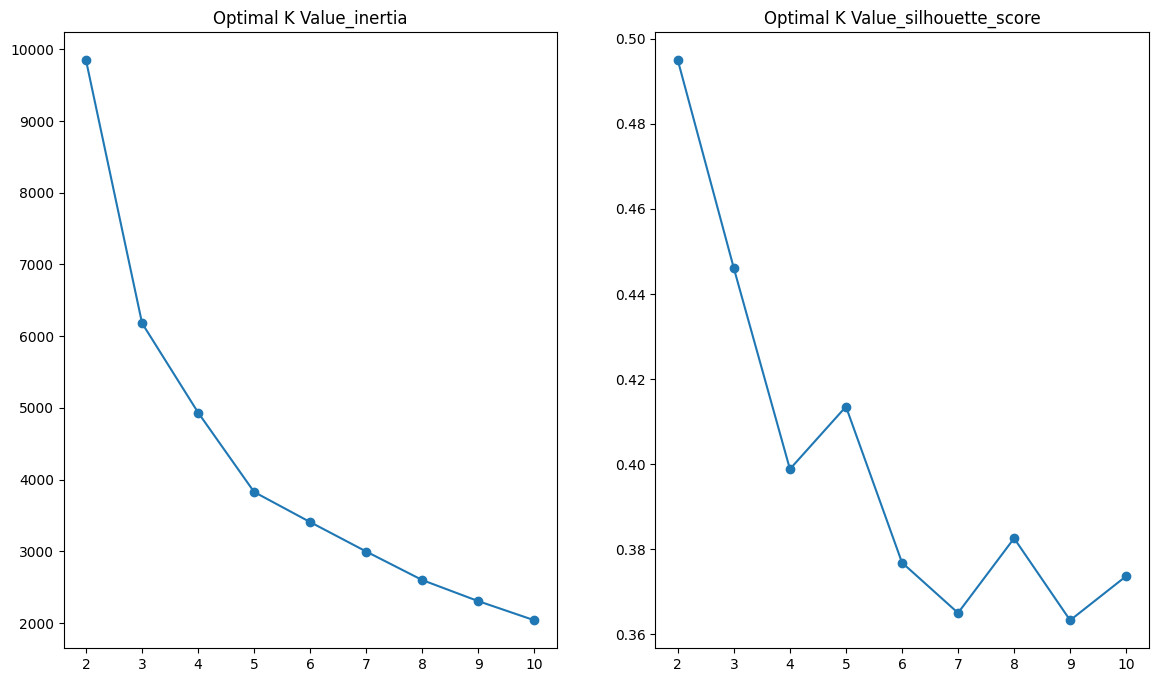

In [74]:
kmeans_find_k_value(df_2012)

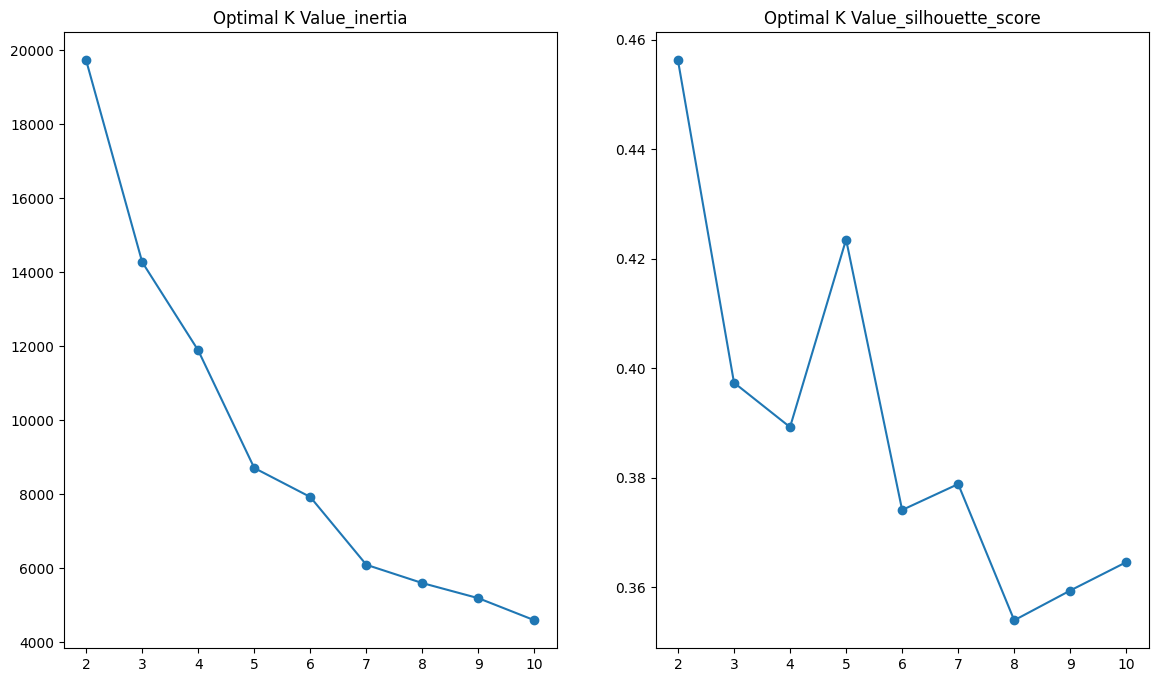

In [75]:
kmeans_find_k_value(df_2016)

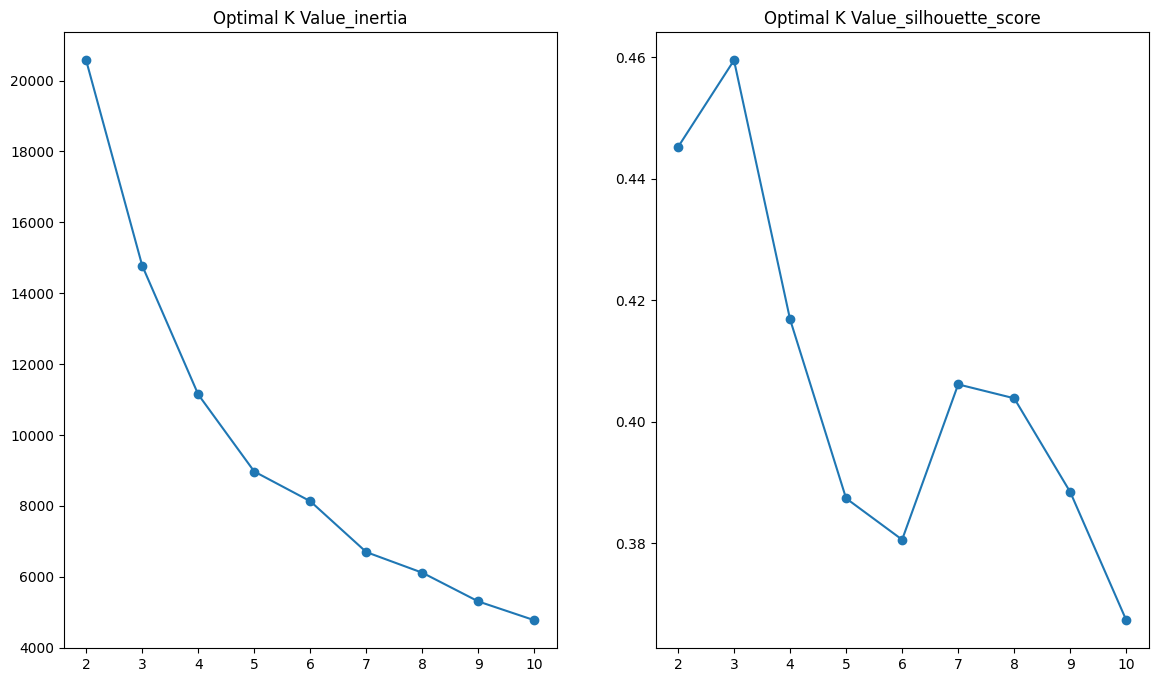

In [76]:
kmeans_find_k_value(df_2020)

The Optimal K Value for these subsets are 2, 2, 3

In [80]:
def kmeans_clustering(df_2012, optimal_k):
    kmeans = KMeans(n_clusters = optimal_k, random_state=42)
    kmeans.fit(df_2012[["Shot_distance_mean","shot_rate", "minleft_mean", "action_type","shot_type","basic_zone","zone_name"]])
    df_2012["Cluster"] = kmeans.labels_
    labels = kmeans.fit_predict(df_2012[["Shot_distance_mean","shot_rate", "minleft_mean", "action_type","shot_type","basic_zone","zone_name"]])
    score = silhouette_score(df_2012[["Shot_distance_mean","shot_rate", "minleft_mean", "action_type","shot_type","basic_zone","zone_name"]], labels)
    print(f"silhouette score: {score}")
    return df_2012, kmeans.cluster_centers_

In [81]:
# print of the silhouette score for my clustering
df_2012, cluster_center2012 = kmeans_clustering(df_2012, 2)
df_2016, cluster_center2016 = kmeans_clustering(df_2016, 2)
df_2020, cluster_center2020 = kmeans_clustering(df_2020, 3)

silhouette score: 0.49494261066698836
silhouette score: 0.45620674919063664
silhouette score: 0.45949131411448924


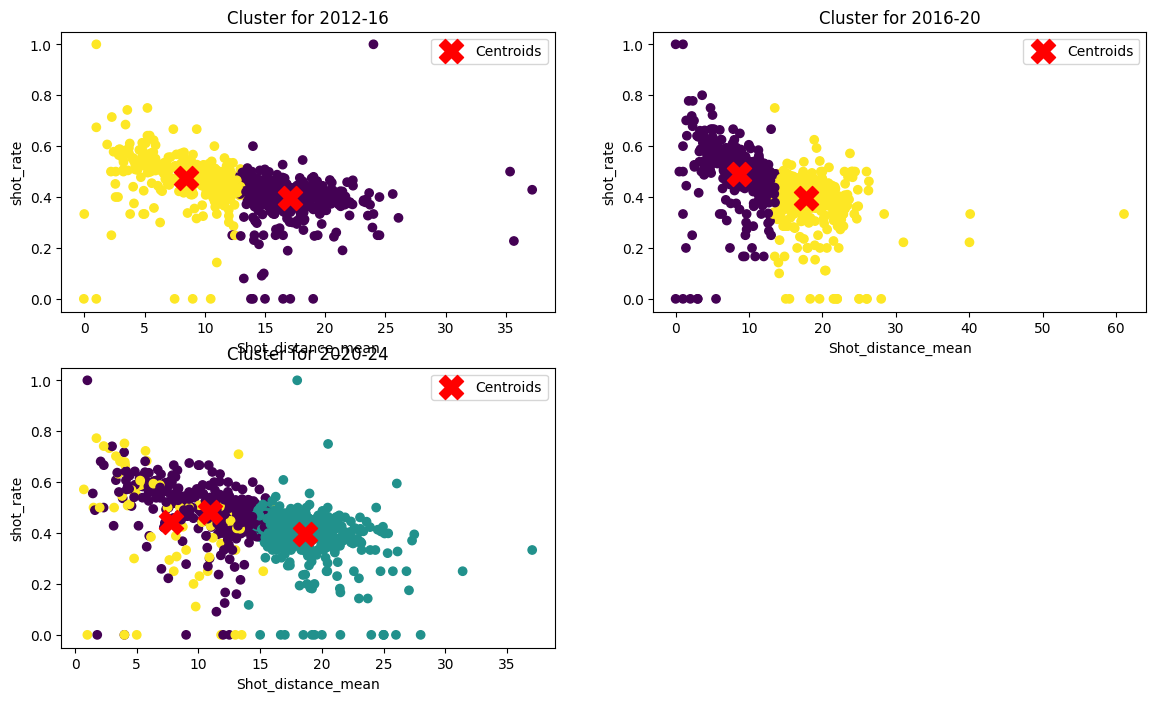

In [82]:
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.scatter(df_2012["Shot_distance_mean"], df_2012["shot_rate"], c=df_2012["Cluster"], cmap = "viridis")
plt.scatter(cluster_center2012[:, 0], cluster_center2012[:,1], s=300, c = 'red', marker = 'X', label = 'Centroids')
plt.xlabel("Shot_distance_mean")
plt.ylabel("shot_rate")
plt.title("Cluster for 2012-16")
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(df_2016["Shot_distance_mean"], df_2016["shot_rate"], c=df_2016["Cluster"], cmap = "viridis")
plt.scatter(cluster_center2016[:, 0], cluster_center2016[:,1], s=300, c = 'red', marker = 'X', label = 'Centroids')
plt.xlabel("Shot_distance_mean")
plt.ylabel("shot_rate")
plt.title("Cluster for 2016-20")
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(df_2020["Shot_distance_mean"], df_2020["shot_rate"], c=df_2020["Cluster"], cmap = "viridis")
plt.scatter(cluster_center2020[:, 0], cluster_center2020[:,1], s=300, c = 'red', marker = 'X', label = 'Centroids')
plt.xlabel("Shot_distance_mean")
plt.ylabel("shot_rate")
plt.title("Cluster for 2020-24")
plt.legend()
plt.show()



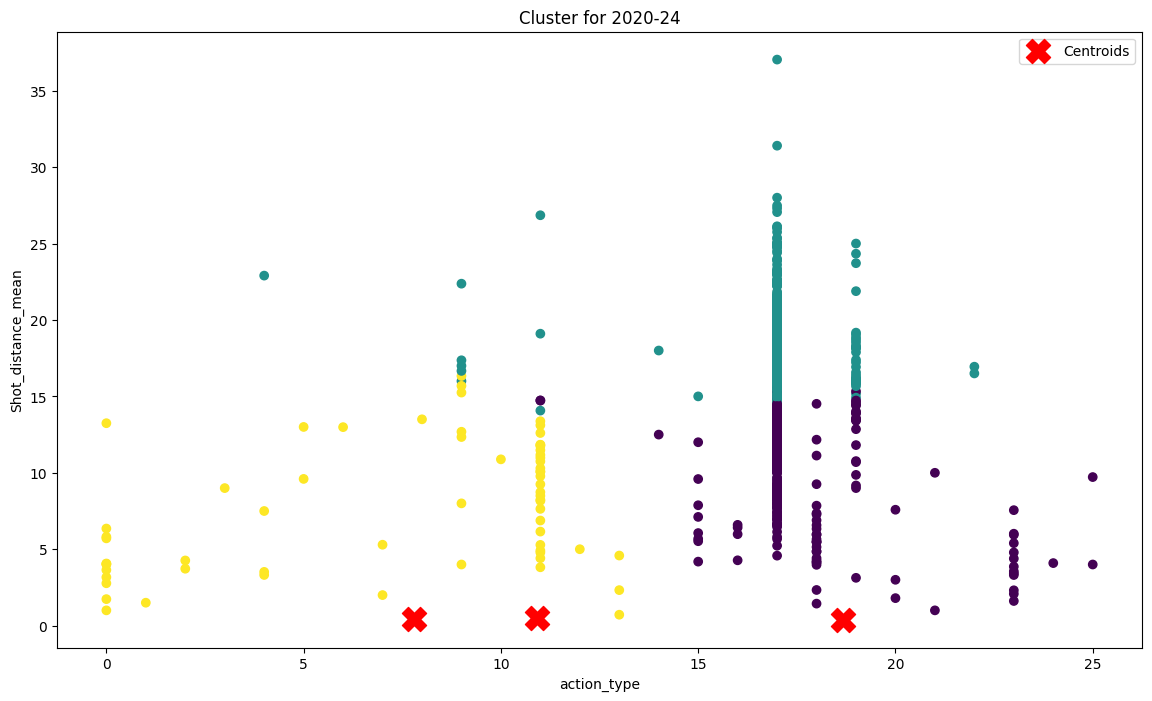

In [83]:
plt.figure(figsize=(14, 8))
plt.scatter(df_2020["action_type"], df_2020["Shot_distance_mean"], c=df_2020["Cluster"], cmap = "viridis")
plt.scatter(cluster_center2020[:, 0], cluster_center2020[:,1], s=300, c = 'red', marker = 'X', label = 'Centroids')
plt.xlabel("action_type")
plt.ylabel("Shot_distance_mean")
plt.title("Cluster for 2020-24")
plt.legend()
plt.show()

### Analyze the Result
For the clustering result of 2012-2016 and 2016-2020 dataset, we observed that clusters are highly correlated with shot distance. Moreover, the centroids of clusters tend to move downward when shot distance decreased. 

When observing the 2020-2024 dataset clustering result, we can find a shift in clustering behavior. The clustering was influenced by both action type and shot distance, where lower-labeled action type categories clustered together, and higher-labeled action type categories were split in two groups based on shot distance.

Insight: 
Through the analysis above, we can identify how different shot distances and shot types influence the success rate. We can derive strategies for shot distance and action type to refine shooting techniques for obtaining higher score.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 3. Prediction Task (No Deep Learning)



Build a model to predict shot success (SHOT_MADE) given available features, and improve their accuracy by creating features and hyperparameter tuning. You may drop some features if you feel that they would improve your accuracy. 

You are given the train and test splits (run the first cell and look into the `datasets` folder). Note that the test file does NOT contain labels! The test.csv is what you will ultimately make predictions on. You are free to split the train.csv file into its own train-test splits as you like. 

Feature engineering can include:
- Spatial features (shot angle derived from LOC_X, LOC_Y).
- Shot difficulty: A derived feature combining SHOT_DISTANCE, LOC_X, LOC_Y, and SHOT_TYPE.
- Player fatigue: An engineered metric estimating player fatigue based on game date (GAME_DATE) and time in the game.

Prediction methods can include logistic regression, decision trees, random forests, gradient boosting, etc (including things we haven't covered!). However, you are NOT allowed to use deep learning for this task. 

Objective: Beat the benchmark accuracy score on the test set (`test.csv`). Create a submission file following the format of 'submission_example.csv' and upload to Kaggle. Kaggle will run accuracy calculation and show you how you rank amongst the submissions of others.

#### Creating the submission file. 



You should follow the format of `submission.csv` (also provided):

```{python}
submission_df = pd.read_csv("./submission.csv", index_col=0)
submission_df['SHOT_MADE'] = # your predictions
submission_df.to_csv("./submission.csv", index=True, index_label="ID")
```

Then upload the file to the Kaggle competition to get your leaderboard score. 

I ran my prediction code on COLAB.

In [32]:
df_test = pd.read_csv("datasets/test.csv")

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# split data into train dataset and validation dataset
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(df.drop("SHOT_MADE", axis=1), df["SHOT_MADE"], test_size=0.2, random_state=1)

In [ ]:
# Feature Engineering: calculate the player's shot successful rate
def count_shot_rate(X_train, X_test):
    shot_made = df.groupby(["PLAYER_NAME"]).size().reset_index()
    shot_made = shot_made.rename(columns = {0:"SHOT_COUNT"})
    shot_success = df[df["SHOT_MADE"] == True]
    shot_success = shot_success.groupby(["PLAYER_NAME"]).size().reset_index()
    shot_success = pd.DataFrame(shot_success)
    shot_success = shot_success.rename(columns = {0:"SHOTS_MADE"})
    ans = shot_success.merge(shot_made, on = ["PLAYER_NAME"])
    ans["SHOT_SUCCESS_RATE"] = ans["SHOTS_MADE"] / ans["SHOT_COUNT"]
    X_train = X_train.merge(ans[["PLAYER_NAME","SHOT_SUCCESS_RATE"]], on = ["PLAYER_NAME"],how = "left")
    X_test = X_test.merge(ans[["PLAYER_NAME","SHOT_SUCCESS_RATE"]], on = ["PLAYER_NAME"], how = "left")
    return X_train, X_test

In [ ]:
def preprocess(X_train, X_test):
    # selecting the useful features.
    X_train = X_train[["PLAYER_NAME","PLAYER_ID","GAME_ID","SHOT_DISTANCE","QUARTER","MINS_LEFT","SECS_LEFT","POSITION_GROUP","ACTION_TYPE"]]
    X_test = X_test[["PLAYER_NAME","PLAYER_ID","GAME_ID","SHOT_DISTANCE","QUARTER","MINS_LEFT","SECS_LEFT","POSITION_GROUP","ACTION_TYPE"]]
    X_train, X_test = count_shot_rate(X_train, X_test)
    X_train = X_train.drop(["PLAYER_NAME"], axis=1)
    X_test = X_test.drop(["PLAYER_NAME"], axis=1)
    X_train["time_left"] = X_train["MINS_LEFT"]*60 + X_train["SECS_LEFT"]
    X_train = X_train.drop(["MINS_LEFT","SECS_LEFT"], axis=1)
    X_train["QUARTER"] = X_train["QUARTER"].astype(int)
    X_train["QUARTER"] = X_train["QUARTER"].apply(lambda x: 5 if x > 5 else x)
    X_train = pd.get_dummies(X_train, columns=['POSITION_GROUP',"ACTION_TYPE"])
    X_test["time_left"] = X_test["MINS_LEFT"]*60 + X_test["SECS_LEFT"]
    X_test = X_test.drop(["MINS_LEFT","SECS_LEFT"], axis=1)
    X_test["QUARTER"] = X_test["QUARTER"].astype(int)
    X_test["QUARTER"] = X_test["QUARTER"].apply(lambda x: 5 if x > 5 else x)
    X_test = pd.get_dummies(X_test, columns=['POSITION_GROUP',"ACTION_TYPE"])
    stdScale = StandardScaler()
    X_train_scaled = stdScale.fit_transform(X_train)
    X_test_scaled = stdScale.fit_transform(X_test)
    return X_train_scaled, X_test_scaled

### Feature Choosing
I chose "PLAYER_ID","GAME_ID","SHOT_DISTANCE","QUARTER","MINS_LEFT","SECS_LEFT","POSITION_GROUP","ACTION_TYPE" and successful rate of each player for this prediction model.

I believe the player itself and the game he played is a important feature, where every game have different daily status and difficulty. Other features are selected because they are all related to the shot situation.

In [ ]:
def predict(X_train, X_test, y_train):
    rf = RandomForestClassifier(max_depth=20, random_state=0)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_pred = y_pred.astype(int)
    return y_pred

In [ ]:
# validation test
X_train_pre, X_test_pre = preprocess(X_train_split, X_test_split)
y_pred = predict(X_train_pre, X_test_pre, y_train_split)
accuracy = accuracy_score(y_test_split, y_pred)
print(accuracy)

: 

In [ ]:
# predict the test.csv data
y_train = df["SHOT_MADE"]
X_train_pre, X_test_pre = preprocess(df, df_test)
y_pred_submit = predict(X_train_pre, X_test_pre, y_train)

In [36]:
submission = pd.read_csv("submission.csv")
submission

,ID,SHOT_MADE
0,3036018,0
1,1132843,0
2,567965,0
3,4131341,1
4,3383217,0
...,...,...
846248,3137134,0
846249,1996846,0
846250,3885141,0
846251,3802524,0


In [37]:
submission["SHOT_MADE"] = y_pred
submission

,ID,SHOT_MADE
0,3036018,0
1,1132843,0
2,567965,0
3,4131341,1
4,3383217,0
...,...,...
846248,3137134,0
846249,1996846,0
846250,3885141,0
846251,3802524,0


In [38]:
len(submission[submission['SHOT_MADE'] == 1])

238852

In [39]:
submission.to_csv("submission.csv",index = False)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 4: Optional (Bonus) Advanced visualizations and analysis


This is an optional problem worth 5 bonus points. It is an open-ended question. We are asking you to create a single novel and possibly interactive visualization
that shows an interesting insight into the data. Some examples could be:

- a shot heatmap for players or teams,
- game-winning (or tying) clutch shot analysis
- career makes from a particular player shown on a court graphic
- progression of shots from a particular player (or players at a particular position) over time

However you are free to design this yourself. Earning the bonus should be beyond the scope of a simple EDA and should involve a few steps of analysis prior to the visualization. 

Your plots should be on a professional level visually. This means they should have proper labels, titles, legends, and the font sizes should make the visualization clear.

Since this part is more open-ended than the others, it is optional. 

In [85]:
import seaborn as sns

In [86]:
# first plot: I want to draw a team heapmap to see different shot made and shot count value of each team
def team_heap(df):
    df = df.groupby("TEAM_NAME").agg(Shot_distance_mean = ("SHOT_DISTANCE","mean"), minleft_mean = ("MINS_LEFT","mean"), shot_made = ("SHOT_MADE","sum"), shot_count = ("SHOT_MADE","size"),)
    df["shot_rate"] = df["shot_made"] / df["shot_count"]
    return df
df_team = team_heap(df)

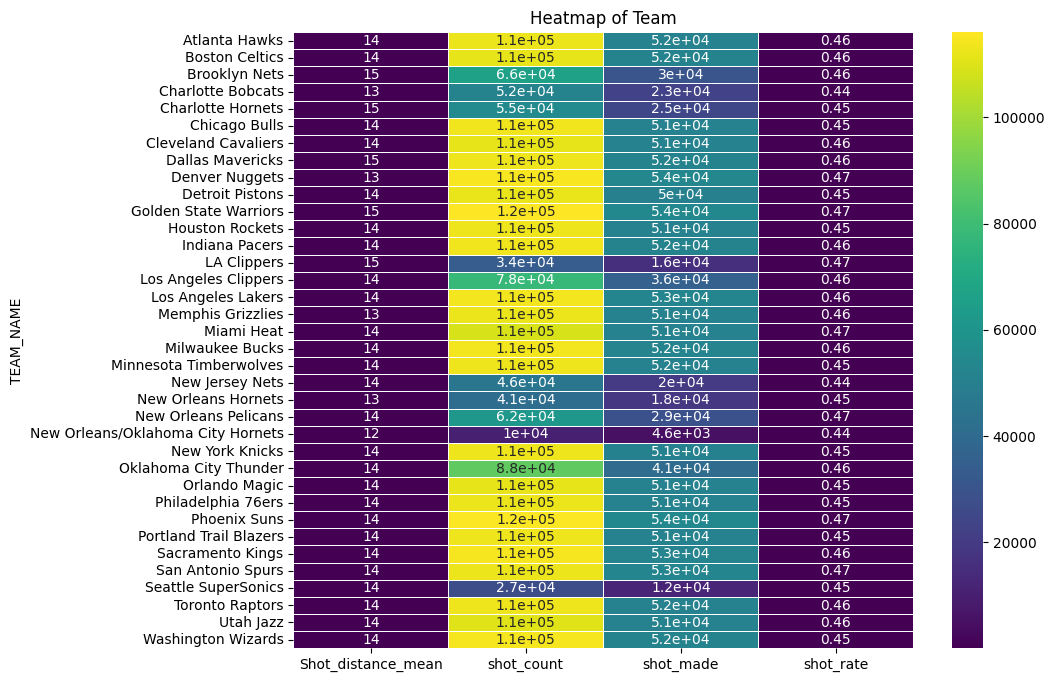

In [87]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_team[["Shot_distance_mean","shot_count","shot_made","shot_rate"]], annot=True, cmap='viridis', linewidths=0.5)
plt.title("Heatmap of Team")
plt.show()

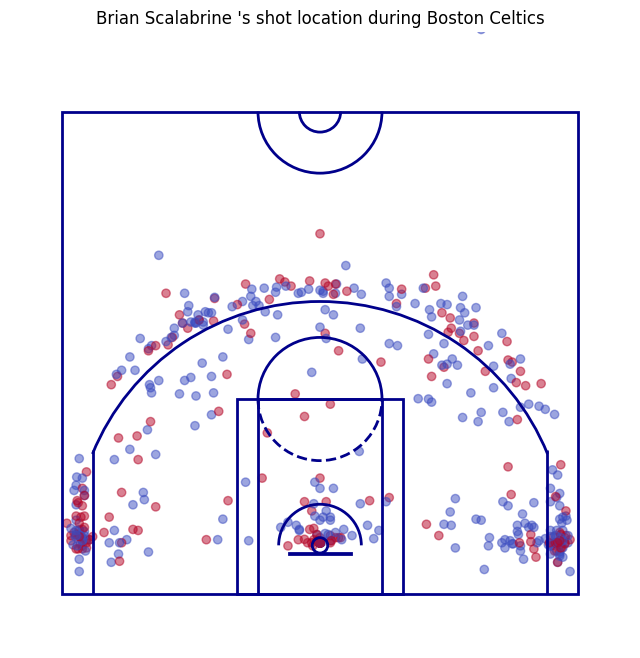

In [88]:
from utils import draw_court
# plot boston celtics team the highest shot successful rate person's shot when he is in Boston Celtics team
game_df = df[(df['TEAM_NAME'] == "Boston Celtics")]
game_df_group = game_df.groupby("PLAYER_NAME").agg(shot_made = ("SHOT_MADE", "sum"), shot_count = ("SHOT_MADE", "size"))
game_df_group = game_df_group[game_df_group["shot_count"] > 500]
game_df_group["success_rate"] = game_df_group["shot_made"] / game_df_group["shot_count"]
game_df_group = game_df_group.sort_values(by = "success_rate")

name = game_df_group.index[0] # Kobe Bryant
game_df = df[(df['PLAYER_NAME'] == name) & (df["TEAM_NAME"] == 'Boston Celtics')]
plt.figure(figsize=(8, 8))
# The 'game_df['LOC_X'] * 10 and (game_df['LOC_Y'] - 5) * 10' operations were chosen arbitrarily, we suggest you keep them.
plt.scatter(game_df['LOC_X'] * 10, (game_df['LOC_Y'] - 5) * 10, c=game_df['SHOT_MADE'], cmap='coolwarm', alpha=0.5)
draw_court(outer_lines=True, color="darkblue")

# These make sure the court is of a reasonable size
plt.title(f"{name} 's shot location during Boston Celtics")
plt.xlim(-300, 300)
plt.ylim(-100, 500)
plt.axis('off')
plt.show()

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)